# Libraries

In [ ]:
import pandas as pd 
import numpy as np
import random as rnd
import matplotlib.pyplot as plt


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)

# Data loading

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/train.tsv',delimiter="\t")
test = pd.read_csv('/content/drive/MyDrive/test_without_tags.tsv',delimiter="\t")
train.head()

,#viewed_ads,#times_visited_website,#products_in_cart,target_product_price,target_product_price_color,target_product_description_length,timestamp,target_product_category,age,shopper_segment,delivery_time,tag
0,16.0,7.0,8,36,red,91,17:43:06,Video games - fifa 18,25.0,new,1-3 days,1
1,10.0,6.0,6,34,black,157,23:19:06,video games - nba 2k,NaN,new,4-8 days,1
2,9.0,7.0,6,36,red,86,02:46:41,Video games - fifa 19,36.0,new,15+ days,0
3,NaN,6.0,6,32,red,121,08:35:20,video games - tekken,32.0,heavy shopper,4-8 days,1
4,8.0,NaN,8,56,red,85,07:00:45,Clothing - red hat,NaN,heavy shopper,9-14 days,0


# Data Understanding

## Feature Preparation
let's check how many absent values do we have:



In [ ]:
null_value_stats = train.isnull().sum(axis=0)
null_value_stats[null_value_stats != 0]

#viewed_ads               15911
#times_visited_website    16141
age                       16137
dtype: int64

As we can see, we have some missing values, so let's fill them with some number way out of their distributions - so the model would be able to easily distinguish between them and take it into account:


In [ ]:
train.fillna(-1, inplace=True)
test.fillna(-1, inplace=True)

## Label- tag

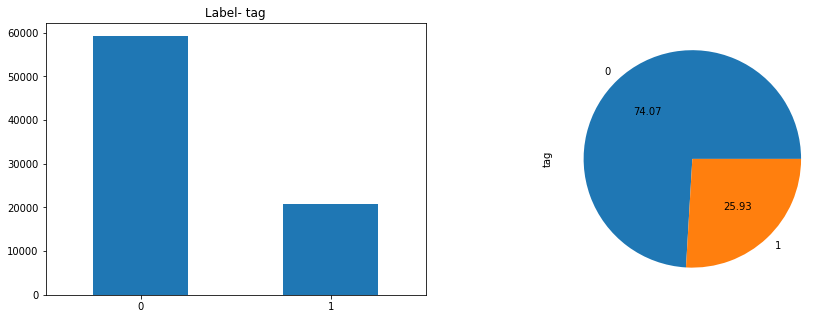

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

ax1 = plt.subplot(1,2,1)
plt.title('Label- tag', loc='center')
train.tag.value_counts().plot(kind='bar')
plt.xticks(rotation=0)

ax2 = plt.subplot(1,2,2)
train.tag.value_counts().plot(kind='pie', autopct='%0.2f', ax=ax2)
plt.show()

so our label is not so balanced, but I want to work with this original probabilities and to handle with the imbalanced data in other ways (weights,stratify,loss, metrics etc.)

## Convert relevant features to categorical:

In [ ]:
col_cat_list = list( train.select_dtypes(exclude=np.number))
col_num_list = list( train.select_dtypes(include=np.number))

col_cat_list.remove('timestamp')
train[col_cat_list] = train[col_cat_list].astype('category')
train["tag"]=train["tag"].astype('category')

# EDA:

In [ ]:
import plotly.express as px
fig = px.scatter(train, x="#viewed_ads", y="target_product_price", color="tag",
                  hover_data=['shopper_segment'], title="target_product_price by viewed_ads and tag")
fig.show()

/usr/local/lib/python3.7/dist-packages/plotly/express/_core.py:286: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



In [ ]:
fig = px.box(train, x="tag", y="#products_in_cart", color="shopper_segment",title="#products_in_cart by shopper_segment for each label")
fig.show()

In [ ]:
fig = px.box(train, x="tag", y="age", color="shopper_segment",title="Boxplot of age by tag and shopper_segment")
fig.show()

# Feature Eng.

### Handle with target_product_category:
we can split this feature to 2 new features, Category and Product, it should make our life easier :)
another option is to create embeddings for each new feature and to use them as numeric features

In [ ]:

train['Category']=train["target_product_category"].str.split("-",n=1, expand = True)[0].str.lower().str.strip()
train['Product']=train["target_product_category"].str.split("-",n=1, expand = True)[1].str.lower().str.strip()
train['Category'] = train['Category'].astype('category')
train['Product'] = train['Product'].astype('category')

train.head()

,#viewed_ads,#times_visited_website,#products_in_cart,target_product_price,target_product_price_color,target_product_description_length,timestamp,target_product_category,age,shopper_segment,delivery_time,tag,Category,Product
0,16.0,7.0,8,36,red,91,17:43:06,Video games - fifa 18,25.0,new,1-3 days,1,video games,fifa 18
1,10.0,6.0,6,34,black,157,23:19:06,video games - nba 2k,-1.0,new,4-8 days,1,video games,nba 2k
2,9.0,7.0,6,36,red,86,02:46:41,Video games - fifa 19,36.0,new,15+ days,0,video games,fifa 19
3,-1.0,6.0,6,32,red,121,08:35:20,video games - tekken,32.0,heavy shopper,4-8 days,1,video games,tekken
4,8.0,-1.0,8,56,red,85,07:00:45,Clothing - red hat,-1.0,heavy shopper,9-14 days,0,clothing,red hat


In [ ]:
fig = px.box(train, x="tag", y="age", color="Product", title="Boxplot of age by tag and Product")
fig.show()

In [ ]:
fig = px.box(train, x="tag", y="age", color="Category",title="Boxplot of age by tag and Category")
fig.show()

### Handle with timestamp feature:
Let's convert the timestamp to hour,min and sec, so it may help to our model to train better more then regular timestamp

In [ ]:
time_convert=train["timestamp"]
time_convert =time_convert.str.split(":",n=2, expand = True)
time_convert.columns=["hour","min","sec"]
train["hour"]=time_convert["hour"].astype('int')
train["min"]=time_convert["min"].astype('int')
train["sec"]=time_convert["sec"].astype('int')
train.head()

,#viewed_ads,#times_visited_website,#products_in_cart,target_product_price,target_product_price_color,target_product_description_length,timestamp,target_product_category,age,shopper_segment,delivery_time,tag,Category,Product,hour,min,sec
0,16.0,7.0,8,36,red,91,17:43:06,Video games - fifa 18,25.0,new,1-3 days,1,video games,fifa 18,17,43,6
1,10.0,6.0,6,34,black,157,23:19:06,video games - nba 2k,-1.0,new,4-8 days,1,video games,nba 2k,23,19,6
2,9.0,7.0,6,36,red,86,02:46:41,Video games - fifa 19,36.0,new,15+ days,0,video games,fifa 19,2,46,41
3,-1.0,6.0,6,32,red,121,08:35:20,video games - tekken,32.0,heavy shopper,4-8 days,1,video games,tekken,8,35,20
4,8.0,-1.0,8,56,red,85,07:00:45,Clothing - red hat,-1.0,heavy shopper,9-14 days,0,clothing,red hat,7,0,45


In [ ]:
train=train.drop(columns=['target_product_category','timestamp'])
train.head()

,#viewed_ads,#times_visited_website,#products_in_cart,target_product_price,target_product_price_color,target_product_description_length,age,shopper_segment,delivery_time,tag,Category,Product,hour,min,sec
0,16.0,7.0,8,36,red,91,25.0,new,1-3 days,1,video games,fifa 18,17,43,6
1,10.0,6.0,6,34,black,157,-1.0,new,4-8 days,1,video games,nba 2k,23,19,6
2,9.0,7.0,6,36,red,86,36.0,new,15+ days,0,video games,fifa 19,2,46,41
3,-1.0,6.0,6,32,red,121,32.0,heavy shopper,4-8 days,1,video games,tekken,8,35,20
4,8.0,-1.0,8,56,red,85,-1.0,heavy shopper,9-14 days,0,clothing,red hat,7,0,45


### Let's separate features and label variable:


In [ ]:
X = train.drop('tag', axis=1)
y = train.tag

since I added new features, I need to update my categorical_features_indices

In [ ]:
print(X.dtypes)
categorical_features_indices = np.where(X.dtypes == 'category')[0]

#viewed_ads                           float64
#times_visited_website                float64
#products_in_cart                       int64
target_product_price                    int64
target_product_price_color           category
target_product_description_length       int64
age                                   float64
shopper_segment                      category
delivery_time                        category
Category                             category
Product                              category
hour                                    int64
min                                     int64
sec                                     int64
dtype: object


In [ ]:
categorical_features_indices

array([ 4,  7,  8,  9, 10])

# Data Splitting

In [ ]:
#split to train,validation and test datasets
from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.85,stratify=y, random_state=42)
X_validation, X_test, y_validation, y_test = train_test_split(X_validation, y_validation, train_size=0.5,stratify=y_validation, random_state=42)


X_train.shape, y_train.shape, X_validation.shape, X_test.shape

((68000, 14), (68000,), (6000, 14), (6000, 14))

# Data Modeling

In [ ]:
pip install catboost

     |████████████████████████████████| 76.3 MB 1.4 MB/s 


I tried 2 models, with other hyperparams in order to see the behavior of the models

In [ ]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
)
model.fit(
    X_train, y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_validation, y_validation),
    verbose=100
)
print('Model is fitted: ' + str(model.is_fitted()))
print('Model params:')
print(model.get_params())

0:	learn: 0.6407206	test: 0.6390884	best: 0.6390884 (0)	total: 98.9ms	remaining: 1m 38s
100:	learn: 0.3949666	test: 0.3814984	best: 0.3814984 (100)	total: 9.56s	remaining: 1m 25s
200:	learn: 0.3847535	test: 0.3783467	best: 0.3783100 (198)	total: 19.8s	remaining: 1m 18s
300:	learn: 0.3771916	test: 0.3780761	best: 0.3780485 (292)	total: 30s	remaining: 1m 9s
400:	learn: 0.3710493	test: 0.3774951	best: 0.3774926 (345)	total: 40.4s	remaining: 1m
500:	learn: 0.3647071	test: 0.3779496	best: 0.3774582 (404)	total: 51.1s	remaining: 50.9s
600:	learn: 0.3595242	test: 0.3775103	best: 0.3774460 (595)	total: 1m 1s	remaining: 41s
700:	learn: 0.3546261	test: 0.3775798	best: 0.3774460 (595)	total: 1m 12s	remaining: 30.9s
800:	learn: 0.3496928	test: 0.3778310	best: 0.3774460 (595)	total: 1m 23s	remaining: 20.7s
900:	learn: 0.3450462	test: 0.3778687	best: 0.3774460 (595)	total: 1m 34s	remaining: 10.3s
999:	learn: 0.3407050	test: 0.3782263	best: 0.3774460 (595)	total: 1m 44s	remaining: 0us

bestTest = 0.3

In [ ]:
model2 = CatBoostClassifier(
    learning_rate=0.01,
    iterations=4000,
    random_seed=26,
)

model2.fit(
    X_train, y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_validation, y_validation),
    verbose=100
)
print('Model2 is fitted: ' + str(model.is_fitted()))
print('Model2 params:')
print(model2.get_params())

0:	learn: 0.6874828	test: 0.6873748	best: 0.6873748 (0)	total: 108ms	remaining: 7m 12s
100:	learn: 0.4608761	test: 0.4523276	best: 0.4523276 (100)	total: 8.03s	remaining: 5m 10s
200:	learn: 0.4237607	test: 0.4114646	best: 0.4114646 (200)	total: 17s	remaining: 5m 21s
300:	learn: 0.4120733	test: 0.3986174	best: 0.3986174 (300)	total: 27s	remaining: 5m 32s
400:	learn: 0.4057730	test: 0.3918328	best: 0.3918328 (400)	total: 37s	remaining: 5m 32s
500:	learn: 0.4019733	test: 0.3879717	best: 0.3879717 (500)	total: 46.9s	remaining: 5m 27s
600:	learn: 0.3995030	test: 0.3856037	best: 0.3856037 (600)	total: 56.6s	remaining: 5m 20s
700:	learn: 0.3974884	test: 0.3837994	best: 0.3837994 (700)	total: 1m 6s	remaining: 5m 11s
800:	learn: 0.3960547	test: 0.3827422	best: 0.3827422 (800)	total: 1m 15s	remaining: 5m 1s
900:	learn: 0.3948619	test: 0.3819354	best: 0.3819354 (900)	total: 1m 24s	remaining: 4m 51s
1000:	learn: 0.3937603	test: 0.3812304	best: 0.3812304 (1000)	total: 1m 34s	remaining: 4m 42s
1100:

## Classification report on test set:

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

model1_preds=model.predict(X_test)
print("Classification Report-Model 1")
print(classification_report(y_test, model1_preds))


Classification Report-Model 1
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      4444
           1       0.79      0.63      0.70      1556

    accuracy                           0.86      6000
   macro avg       0.83      0.79      0.80      6000
weighted avg       0.86      0.86      0.86      6000



In [ ]:
model2_preds=model2.predict(X_test)
print("Classification Report-Model 2")
print(classification_report(y_test, model2_preds))

Classification Report-Model 2
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      4444
           1       0.79      0.62      0.70      1556

    accuracy                           0.86      6000
   macro avg       0.83      0.78      0.80      6000
weighted avg       0.86      0.86      0.85      6000



We can see that we got really good results on the first model, althoug I trained it less then the second model.

## Model Cross-Validation

I did cross validation in order to be sure that the model is robust to all kinds of train\ validation sets

In [ ]:
from catboost import cv, Pool

params = {}
params['loss_function'] = 'Logloss'
params['iterations'] = 1000
params['custom_loss'] = 'AUC'
params['random_seed'] = 63
params['learning_rate'] = 0.1

cv_data = cv(
    params = params,
    pool=Pool(X_train, y_train, cat_features=categorical_features_indices),
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot=False,
    stratified=True,
    verbose=100
)


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Training on fold [0/5]
0:	learn: 0.6396529	test: 0.6388556	best: 0.6388556 (0)	total: 96.3ms	remaining: 1m 36s
100:	learn: 0.3961840	test: 0.3942049	best: 0.3942049 (100)	total: 8.98s	remaining: 1m 19s
200:	learn: 0.3849296	test: 0.3908630	best: 0.3907657 (199)	total: 18.3s	remaining: 1m 12s
300:	learn: 0.3761683	test: 0.3896480	best: 0.3896480 (300)	total: 27.7s	remaining: 1m 4s
400:	learn: 0.3686535	test: 0.3895522	best: 0.3894697 (335)	total: 37s	remaining: 55.3s
500:	learn: 0.3613307	test: 0.3898665	best: 0.3894697 (335)	total: 46.6s	remaining: 46.4s
600:	learn: 0.3549457	test: 0.3900915	best: 0.3894697 (335)	total: 56.2s	remaining: 37.3s
700:	learn: 0.3486142	test: 0.3907573	best: 0.3894697 (335)	total: 1m 5s	remaining: 28.1s
800:	learn: 0.3427028	test: 0.3908886	best: 0.3894697 (335)	total: 1m 15s	remaining: 18.7s
900:	learn: 0.3371780	test: 0.3915372	best: 0.3894697 (335)	total: 1m 25s	remaining: 9.36s
999:	learn: 0.3317593	test: 0.3919991	best: 0.3894697 (335)	total: 1m 34s	rem

# Shap values

In [ ]:
pip install shap

     |████████████████████████████████| 371 kB 5.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for shap: filename=shap-0.40.0-cp37-cp37m-linux_x86_64.whl size=509232 sha256=f9711dca250a5cfedf295c91b1282f5b1b26b14a36c5843ad7e2d2723d17b903
  Stored in directory: /root/.cache/pip/wheels/ec/35/84/e304841ac4b910bc95fe9a6e5302eb2507b4333728851dcbfb
Successfully built shap


In [ ]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

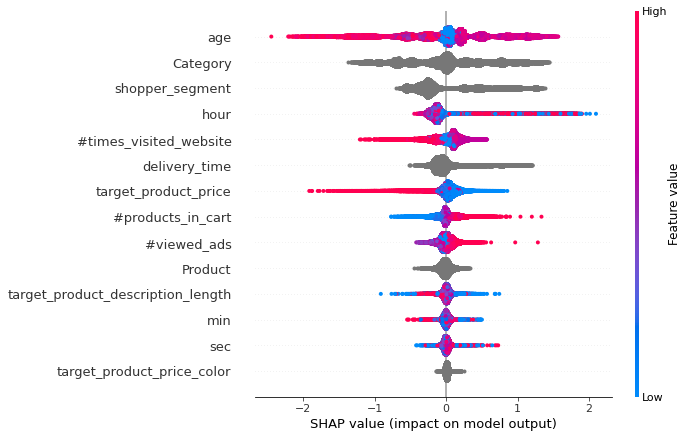

In [ ]:
shap.summary_plot(shap_values, X_train)

understanding shap: we can learn from our numeric features, how they are affect on our label. Since I didnt told the model if the categorical features are ordinal or not and thats why we can't see the affect of our categorical features, I can solve it by converting the categorical features to one-hot encoding and it may help us to understand the impact on model output

# Model Applying

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 11 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   #viewed_ads                        20000 non-null  float64
 1   #times_visited_website             20000 non-null  float64
 2   #products_in_cart                  20000 non-null  int64  
 3   target_product_price               20000 non-null  int64  
 4   target_product_price_color         20000 non-null  object 
 5   target_product_description_length  20000 non-null  int64  
 6   timestamp                          20000 non-null  object 
 7   target_product_category            20000 non-null  object 
 8   age                                20000 non-null  float64
 9   shopper_segment                    20000 non-null  object 
 10  delivery_time                      20000 non-null  object 
dtypes: float64(3), int64(3), object(5)
memory usage: 1.7+ 

In [ ]:
col_cat_list = list( test.select_dtypes(exclude=np.number))
col_num_list = list( test.select_dtypes(include=np.number))

col_cat_list.remove('timestamp')
test[col_cat_list] = test[col_cat_list].astype('category')

test['Category']=test["target_product_category"].str.split("-",n=1, expand = True)[0].str.lower().str.strip()
test['Product']=test["target_product_category"].str.split("-",n=1, expand = True)[1].str.lower().str.strip()
test['Category'] = test['Category'].astype('category')
test['Product'] = test['Product'].astype('category')

time_convert=test["timestamp"]
time_convert =time_convert.str.split(":",n=2, expand = True)
time_convert.columns=["hour","min","sec"]
test["hour"]=time_convert["hour"].astype('int')
test["min"]=time_convert["min"].astype('int')
test["sec"]=time_convert["sec"].astype('int')
test.head()


test=test.drop(columns=['target_product_category','timestamp'])
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   #viewed_ads                        20000 non-null  float64 
 1   #times_visited_website             20000 non-null  float64 
 2   #products_in_cart                  20000 non-null  int64   
 3   target_product_price               20000 non-null  int64   
 4   target_product_price_color         20000 non-null  category
 5   target_product_description_length  20000 non-null  int64   
 6   age                                20000 non-null  float64 
 7   shopper_segment                    20000 non-null  category
 8   delivery_time                      20000 non-null  category
 9   Category                           20000 non-null  category
 10  Product                            20000 non-null  category
 11  hour                               20000 

In [ ]:
predictions = model.predict(test)
predictions = pd.DataFrame(predictions, columns=['predictions']).to_csv('/content/drive/MyDrive/Companies/preds.csv')